# Week 2: Tutorial
# Our genomes, our selves: Ancestry Inference

### Set your individual

In [8]:
# REPLACE with your individual ID
my_individual = 'NA18525'

## Installing packaging and linking to data on github (runtime: 2m)

In [9]:
%cd /content/
!rm -rf Spring-2024

/content


In [10]:
# %%capture
!export LD_LIBARY_PATH=/usr/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH
!apt install libgsl-dev
!ln -s /usr/lib/x86_64-linux-gnu/libgsl.so /usr/lib/x86_64-linux-gnu/libgsl.so.0
!git clone https://github.com/CCB293/Spring-2024
!chmod +x Spring-2024/bin/smartpca
!chmod +x Spring-2024/bin/admixture
!cd Spring-2024/data/1000G && unzip 1000G.geno.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgsl-dev is already the newest version (2.7.1+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
ln: failed to create symbolic link '/usr/lib/x86_64-linux-gnu/libgsl.so.0': File exists
Cloning into 'Spring-2024'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 134 (delta 27), reused 50 (delta 19), pack-reused 73
Receiving objects: 100% (134/134), 91.09 MiB | 26.51 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Archive:  1000G.geno.zip
  inflating: 1000G.geno              


In [11]:
# load the libraries
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import colorsys
import seaborn as sns
from IPython.display import Image
import os

In [12]:
# define plotting functions

def plot_pcs(pcs, I, J, labels, indivs=None):
    PCI = 'PC{}'.format(I)
    PCJ = 'PC{}'.format(J)
    plt.figure(figsize=(10,10))
    #colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,len(np.unique(labels))+1)[:-1]]
    #colors = ['#acc2d9', '#653700', '#b2996e', '#a8ff04', 'xkcd:orange', '#894585',
    #          '#70b23f', '#d4ffff', '#65ab7c', '#952e8f', '#fcfc81', '#a5a391',
    #          '#388004', '#4c9085', '#5e9b8a', '#efb435', '#d99b82', '#0a5f38',
    #          '#0c06f7', '#61de2a', '#3778bf', '#2242c7', '#533cc6', '#9bb53c',
    #          '#05ffa6', '#1f6357', '#017374', '#0cb577']

    colors = [
        "#7e1e9c", "#15b01a", "#0343df", "#ff81c0","#653700","#e50000","#029386",
        "#f97306", "#96f97b", "#c20078", "#ffff14", "#95d0fc", "#929591",
        "#9a0eea",
        "#033500",
        "#00035b",
        "#06c2ac",
        "#d1b26f",
        "#00ffff",
        "#650021",
        "#ffb07c",
        "#ff796c",
        "#36013f",
        "#c65102",
        "#000000",
        "#c1f80a",
        "#4b5d16",
        "#0652ff"
    ]


    print(len(np.unique(labels)))
    for i, p in enumerate(np.unique(labels)):
        pcs_p = pcs[labels==p]
        plt.scatter(pcs_p[PCI], pcs_p[PCJ], label=p, color=colors[i])
    plt.legend(loc=(1.04,0))
    if indivs is not None:
        for individual in indivs:
            pcs_i = pcs[pcs.Sample==individual]
            plt.annotate(individual, [pcs_i[PCI], pcs_i[PCJ]])
            plt.plot(pcs_i[PCI], pcs_i[PCJ], 'o', color='black')
    plt.xlabel(PCI)
    plt.ylabel(PCJ);


def plot_admixture(admixture, population_indices, population_labels):
    plot = plt

    N,K = admixture.shape
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    text_color = 'k'
    bg_color = 'w'
    fontsize = 24

    figure = plot.figure(figsize=(5,3))

    xmin = 0.13
    ymin = 0.2
    height = 1.2#0.6
    width = 1.5#0.74
    indiv_width = width/N
    subplot = figure.add_axes([xmin,ymin,width,height])
    [spine.set_linewidth(0.001) for spine in subplot.spines.values()]

    for k in np.arange(K):
        if k:
            bottoms = admixture[:,:k].sum(1)
        else:
            bottoms = np.zeros((N,),dtype=float)

        lefts = np.arange(N)*indiv_width
        subplot.bar(lefts, admixture[:,k], width=indiv_width, bottom=bottoms, facecolor=colors[k], edgecolor=colors[k], linewidth=0.4)

        subplot.axis([0, N*indiv_width, 0, 1])
        subplot.tick_params(axis='both', top=False, right=False, left=False, bottom=False)
        xtick_labels = tuple(map(str,['']*N))
        subplot.set_xticklabels(xtick_labels)
        ytick_labels = tuple(map(str,['']*K))
        subplot.set_yticklabels(ytick_labels)

    for p,popname in enumerate(population_labels):
        indices = np.where(population_indices==p)[0]
        if indices.size>0:
            vline_pos = (indices.max()+1)*indiv_width
            subplot.axvline(vline_pos, linestyle='-', linewidth=0.2, c='#888888')
            label_position = (xmin+(2*indices.min()+indices.size)*0.5*indiv_width, ymin-0.01)
            figure.text(label_position[0], label_position[1], popname, fontsize=12, color='k', \
                horizontalalignment='right', verticalalignment='top', rotation=70)

    return figure

def plot_admix_individual(admix, individual):
    K = admix.shape[1]
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    plt.pie(admix[individuals.individual==individual][0], colors=colors)
    plt.title(individual);

In [13]:
# set current directory
%cd Spring-2024/data/1000G/

/content/Spring-2024/data/1000G


## Exploring data: 1000 Genomes Project (1000G)
1000 Genomes Project Consortium. (2015). A global reference for human genetic variation. Nature, 526(7571), 68.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4750478/

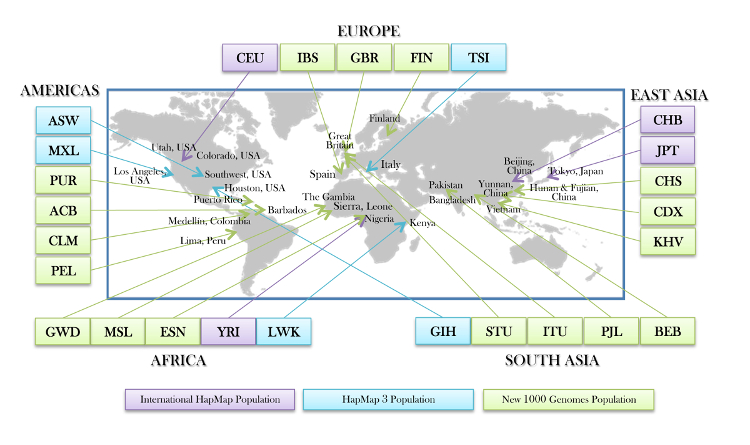

In [14]:
from IPython.display import Image
Image(filename='1000G.png',width=700)

### Individual File.
For more information about file formats, refer to: https://reich.hms.harvard.edu/software/InputFileFormats

In [15]:
individuals = pd.read_csv('1000G.ind', delim_whitespace=True, header=None, names=['individual', 'sex', 'population'])
individuals.head()

individual sex population
0    HG00096   m        GBR
1    HG00097   f        GBR
2    HG00099   f        GBR
3    HG00100   f        GBR
4    HG00101   m        GBR

**1000 Genomes superpopulations:** <br>
&emsp;&emsp;AFR = Africa<br>
&emsp;&emsp;EUR = Europe<br>
&emsp;&emsp;SAS = South Asia<br>
&emsp;&emsp;EAS = East Asia<br>
&emsp;&emsp;AMR = Americas<br>

In [16]:
# merge with population_info file
population_info = pd.read_csv('population_info.csv')
individuals = individuals.merge(population_info, on='population', how='left')
individuals.population = individuals.population.astype('category')
individuals.super_population = pd.Categorical(
    individuals.super_population,
    categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'],
    ordered=True)
# sort individuals by population
individuals = individuals.sort_values(['super_population', 'population'])
# order individual indexes
order = individuals.index
# Set my_individual's continental group
my_individual_index = np.where(individuals.individual==my_individual)[0][0]
my_continental_group = individuals.iloc[my_individual_index].super_population

# show final dataframe
individuals.tail()

individual sex population                     description super_population
466    HG01403   f        PUR  Puerto Ricans from Puerto Rico              AMR
467    HG01405   m        PUR  Puerto Ricans from Puerto Rico              AMR
468    HG01412   m        PUR  Puerto Ricans from Puerto Rico              AMR
469    HG01413   m        PUR  Puerto Ricans from Puerto Rico              AMR
470    HG01414   f        PUR  Puerto Ricans from Puerto Rico              AMR

#### Stop! Check your understanding
1. How many individuals are there in this dataset?
2. How many populations are there in this dataset?

###SNP file

In [ ]:
snps = pd.read_csv('1000G.snp', delim_whitespace=True, header=None, names=['id', 'chr', 'recomb. rate', 'position', 'allele 1', 'allele 2'])
print(snps.shape)
snps.head()

#### Stop! Check your understanding
1. How many SNPs are in this dataset?
2. What is the highest local recombination rate in this dataset?

### Genotype file (runtime: ~1m)

In [ ]:
genotypes = pd.read_fwf('1000G.geno', widths=np.ones(2504, dtype=int).tolist(), header=None)
print(genotypes.shape)
genotypes.head()

# Principal Component Analysis (PCA)

Reference for PCA: https://www.cs.cmu.edu/~venkatg/teaching/CStheory-infoage/book-chapter-4.pdf

More about SVD: https://en.wikipedia.org/wiki/Singular_value_decomposition

The central idea of PCA is :
1. Reduce the dimensionality of a data set that has a large number of interrelated variables,
2. Retain as much as possible of the variation present in the
data set.

This is achieved by transforming to a new set of variables (PCs)
1. which are uncorrelated (orthogonal), and
2. which are ordered so that (hopefully) the first few retain most of the variation present in all of the original variables.

In [ ]:
Image(filename='PCA.gif',width=700)

Patterson, Nick, Alkes L. Price, and David Reich. "Population structure and eigenanalysis." PLoS genetics 2.12 (2006): e190.

https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190

Software documentation: https://github.com/DReichLab/EIG/tree/master/POPGEN

Usage: `!../../bin/smartpca -p 1000G.smartpca.par`

Parameter file (1000G.smartpca.par)

In [ ]:
%%writefile 1000G.smartpca.par
genotypename: 1000G.geno     # file with genotype information
snpname:      1000G.snp      # file with snp information
indivname:    1000G.ind      # file with individual information
evecoutname:  1000G.evec     # output file of eigenvectors.
evaloutname:  1000G.eval     # output file of all eigenvalues
snpweightoutname: 1000G.Weightout.txt
phylipname:   1000G.phyl     # file with Fst values across populations
numoutevec:   10               # number of PCs to output
numthreads:   1                # if running interactively, use 1 only
outliermode: 2
#outliermode should be 0, 1 or 2
#mode = 2  NO outlier removal
#mode = 1  when calculating mean and standard deviation of a PC to decide whether to remove a sample the
# sample itself is not used.   This may be important for datasets with very small sample sizes (say less than 30).
#mode = 0  (default) use all samples to compute PC mean and variance.

### Run smartpca (runtime ~1min)

In [ ]:
!../../bin/smartpca -p 1000G.smartpca.par > pca.out

Display results - evec file. File contains loadings for each individual on the 10 PCs. <br>https://github.com/DReichLab/EIG/tree/master/POPGEN

In [ ]:
n_pcs = 10
pcs = pd.read_csv('1000G.evec', skiprows=1, header=None, delim_whitespace=True,
                       names=['Sample']+['PC'+str(i+1) for i in range(n_pcs)]+['population'])
pcs = pcs.merge(population_info, on='population', how='left')
pcs.head()

### Plot results (PC1 vs. PC2) by superpopulation

In [ ]:
# Plot the top two PCs. Population labels = super_population
plot_pcs(pcs, 1, 2, pcs.super_population, [my_individual])

### Plot results (PC1 vs. PC2) by continental group

In [ ]:
# Plot the top two PCs. Population labels = population
plot_pcs(pcs, 1, 2, pcs.population, [my_individual])

### Assess variance explained by PCs

In [ ]:
eigenvalues = np.loadtxt('1000G.eval')
plt.plot(np.arange(1, 21), 100 * eigenvalues[:20] / eigenvalues.sum())
plt.xticks(np.arange(1, 21));
plt.xlabel('PCs')
plt.ylabel('percent variance explained');

### Check Fst result
The smartpca program also outputs useful statistics after each run. One of these files, [name].phyl, has information about Fst values between all populations within your superpopulation.<br>
<br>
&emsp;&emsp;<ins>Fst</ins>: a measure of genetic differentiation between two populations, based on within-population structure.

In [ ]:
!cat '1000G.phyl'

## Exercise: explore your continental group

#### Run PCA

In [ ]:
np.savetxt('pop.list', individuals[individuals.super_population==my_continental_group].population.unique().astype(str), fmt='%s')

In [ ]:
%%writefile 1000G.continent.smartpca.par
genotypename: 1000G.geno     # file with genotype information
snpname:      1000G.snp      # file with snp information
indivname:    1000G.ind      # file with individual information
poplistname:  pop.list # list of pops to include in the run.
evecoutname:  1000G.continent.evec     # output file of eigenvectors.
evaloutname:  1000G.continent.eval     # output file of all eigenvalues
snpweightoutname: 1000G.continent.Weightout.txt
phylipname:   1000G.continent.phyl     # file with Fst values across populations
numoutevec:   10               # number of PCs to output
numthreads:   1                # if running interactively, use 1 only
outliermode: 2

**Run smartpca (runtime ~30s)**

In [ ]:
!../../bin/smartpca -p 1000G.continent.smartpca.par > pca.out

In [ ]:
# Display output
n_pcs = 10
pcs = pd.read_csv('1000G.continent.evec', skiprows=1, header=None, delim_whitespace=True,
                       names=['Sample']+['PC'+str(i+1) for i in range(n_pcs)]+['population'])
pcs = pcs.merge(population_info, on='population', how='left')
pcs = pcs[pcs.super_population==my_continental_group]
pcs.head()

#### Plot results (PC1 vs. PC2) by population

In [ ]:
# plot PCA output


### Stop! Check your understanding
1. Check your individual in our individuals dataframe; what is their sex, population, and superpopulation? Is your PCA result consistent with that?

2. Find the value of Fst between your population and every other one in the superpopulation.

# Admixture analysis

Alexander, David H., John Novembre, and Kenneth Lange. "Fast model-based estimation of ancestry in unrelated individuals." Genome research 19.9 (2009): 1655-1664.

https://genome.cshlp.org/content/19/9/1655.full

Software documentation: http://dalexander.github.io/admixture/admixture-manual.pdf
Usage:

```!../../bin/admixture --cv 1000G.bed K```

where K = number of clusters

Data format: Plink https://www.cog-genomics.org/plink/1.9/formats#bed

### K = 2

#### Run admixture with K=2 clusters (runtime: ~4m)

In [ ]:
!../../bin/admixture --cv 1000G.bed 2

Output of ADMIXTURE (K=2)

Each line in the output of ADMIXTURE contains the probability of an individual belonging to each cluster - not be to confused with ancestry proportion.

In [ ]:
admix = pd.read_csv('1000G.2.Q', ' ', header=None).values[order]
admix

#### Plot ADMIXTURE result by continental group

In [ ]:
plot_admixture(admix, individuals.super_population.cat.codes, individuals.super_population.cat.categories);

#### Plot ADMIXTURE result by population

In [ ]:
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

#### Plot ADMIXTURE output for your current individual

In [ ]:
plot_admix_individual(admix, my_individual)

### Exercise: K = 3,4,5,6

#### K = 3

In [ ]:
# load ADMIXTURE result file

In [ ]:
# plot admixture result by population

In [ ]:
# plot admixture result for your individual

#### K = 4

In [ ]:
# load ADMIXTURE result file

In [ ]:
# plot admixture result by population

In [ ]:
# plot admixture result for your individual

#### K = 5

In [ ]:
# load ADMIXTURE result file

In [ ]:
# plot admixture result by population

In [ ]:
# plot admixture result for your individual

#### K = 6

In [ ]:
# load ADMIXTURE result file

In [ ]:
# plot admixture result by population

In [ ]:
# plot admixture result for your individual

### How to choose K value
Use ADMIXTURE’s cross-validation procedure. A good value of K will exhibit a low
cross-validation error compared to other K values. Cross-validation is enabled by simply
adding the `--cv` flag to the ADMIXTURE command line. In this default setting, the
cross-validation procedure will perform 5-fold CV—you can get 10-fold CV, for example,
using `--cv=10`. The cross-validation error is reported in the output.

In [ ]:
# %%bash
# for i in {2..6}
# do
#   ../../bin/admixture --cv 1000G.bed $i  | tee log${i}.out
# done

In [ ]:
## Take a look at the output.
# !grep -h "CV" log*.out

In [ ]:
## plot elbow
l = [0.45627,0.43727,0.43260,0.42916,0.42901,0.43249,0.43334,0.43428]
k = range(2, 10)
plt.plot(k, l)
plt.xlabel("k value")
plt.ylabel("CV error")
plt.title('Elbow plot for k values')